In [1]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
from drivers.tree_builder import TreeNeo
from drivers.graph_models import TreeNode, Order, Family, graph,Kingdom,Occurrence
from drivers.graph_models import Cell,Mex4km, countObjectsOf
from drivers.graph_models import pickNode
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import numpy as np

## Use the ggplot style
plt.style.use('ggplot')

# Spatial Regression for presences of certain taxon
---
Abstraction dashboard for joininig the data with the model

***
Here I show how to extract different taxonomic information at cell level.
Although there exists a method for building the taxonomic tree within a single cell, the process can be computationally intensive because it depends on extracting the total amount of occurrences in each cell. From there, it traverses from top to bottom the tree looking for the corresponding nodes.

The approach is usefull when one needs a small number of trees but it'll become increasingly slow if the amount of cells or occurrences increases. 

---

## Extracting specific taxonomic levels en each cells

The method studied here makes use of the relationship type `IS_IN` stored in the knowledge graph.

> Developer's note: *There was a problem with the design of the OGM implementation (py2neo.ogm). The retrieval of linked nodes based on a specific relation does not distinguish different labels. In other words it returns the totality of the data that has the  specific relationship given a node.*

> Patchy solution: 
The solution was to include extra methods for the class Cell `has_[taxas]`. This method/attribute returns a graph selector that points to the corresponding nodes.

> Stable Fix: 
Make relationships as specific as possible (given the data). For example, if instead of using the relation type 
* *IS_IN* for (Bursera:Family) -[IS_IN]-> (Grid:Cell) 
change it to:
* *Family_IS_IN* for (Bursera:Family) -[IS_IN]-> (Grid:Cell)
Let's get started.
As usual we need to load the necessary modules


## The results are already stored in a DataFrame object in:
"/outputs/sample_importantfams_bats.csv"

In [2]:
datatot = pd.read_csv("/outputs/sample_importantfams_bats.csv")
datatot.columns

Index([u'Unnamed: 0', u'3073', u'7717', u'5386', u'6701', u'4691', u'3065',
       u'2393', u'7708', u'6685', u'8798', u'Elevation_mean',
       u'MaxTemperature_mean', u'MeanTemperature_mean', u'MinTemperature_mean',
       u'Precipitation_mean', u'SolarRadiation_mean', u'Vapor_mean',
       u'WindSpeed_mean', u'Longitude', u'Latitude'],
      dtype='object')

## Obtaining the predictors
In this case we will bring all the variables to start working with everything

In [3]:
from raster_api.tools import RasterData
from raster_api.models import raster_models_dic as models


In [4]:
from sketches.models import Country
from mesh.models import MexMesh

Mexico = Country.objects.filter(name__contains="exico").get()
mexican_cells = MexMesh.objects.filter(cell__intersects=Mexico.geom)

### Obtaining everything

In [5]:
datadict = { key : RasterData(models[key],border=Mexico.geom) for key,value in models.iteritems()}

In [6]:
#from django.db import connections
#connections.close_all()

In [7]:
## Without resamling (whole data)
pixel_size = 0.25
%time datacube_field = map(lambda raster : raster.rescale(pixel_size),datadict.itervalues())
datacube = datacube_field

CPU times: user 296 ms, sys: 28 ms, total: 324 ms
Wall time: 4min 29s


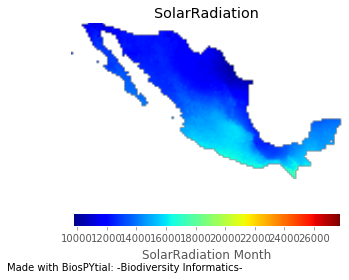

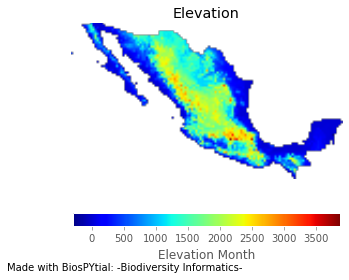

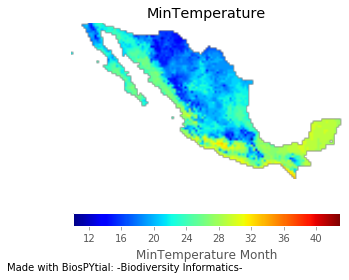

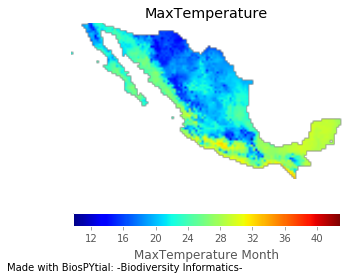

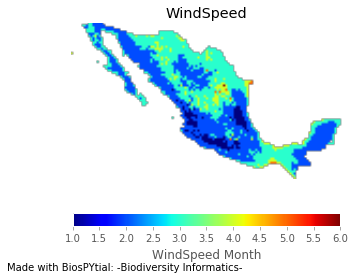

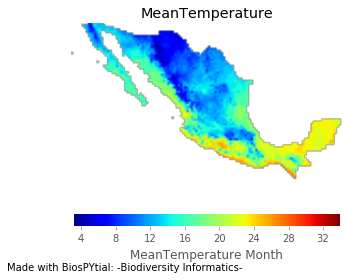

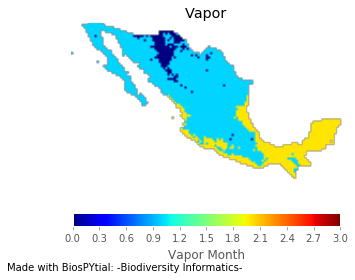

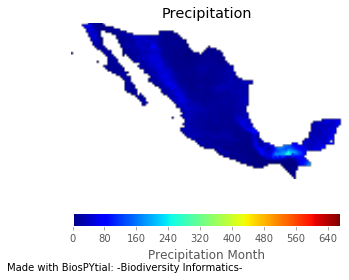

[None, None, None, None, None, None, None, None]

In [8]:
map(lambda (k,d) : d.display_field(title=k,origin='Lower'),datadict.iteritems())

## For the moment we don't want to do temporal analysis so we need to aggregate the array by the mean.

Using the new 'resample' method

In [9]:
# Take mean of everything
cubes = map(lambda (key,value): np.mean(value.toNumpyArray(),axis=0), datadict.iteritems())

The coordinates are the same so, we can extract the them with getCoordinates and then append everything as a flat array

In [16]:
extractCoords = lambda (k,v) : v.getCoordinates() 
coords = extractCoords(datadict.iteritems().next())

In [18]:
## Oke I need a way to extract the dataframe, maybe aggregate it by mean 
dataframe_cube = map(lambda cube: pd.DataFrame(cube.flatten()),cubes)

In [22]:
datacube = pd.concat(dataframe_cube,axis=1)

In [24]:
datacube = pd.concat([datacube,coords],axis=1)

In [26]:
datacube.columns = datadict.keys() + list(coords.columns)

In [27]:
datacube_clean = datacube.dropna()

In [28]:
## Convert to geopandas
from external_plugins.spystats.spystats import tools as tl
datacube_clean = tl.toGeoDataFrame(datacube_clean,xcoord_name='Longitude',ycoord_name='Latitude')

/apps/external_plugins/spystats/spystats/tools.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['geometry'] = data.apply(lambda z : Point(z[xcoord_name], z[ycoord_name]), axis=1)


# Bayesian Modelling

The Model is an inhomogeneous Poisson process.

$y(x) \sim Poisson(\lambda(x)) $

$$ \lambda(x) = exp\{\alpha + S(x)\}$$

Where $S(x)$ is a Gaussian Process such that:
$$S(x) \sim MVN(0,\sigma^2 \rho(||x - x'||) $$

For this particular case:
$$\rho = Matern(\phi,\kappa = \frac{3}{4}) + \tau^2$$

I'm using a Bayesian approach with parameters $\phi$ and $\tau$ as random variables with it's corresponding priors.


In [29]:
datafull = datatot

In [30]:
import pymc3 as pm
#datafull.columns = [u'n_Family', u'Longitude', u'Latitude', u'Elevation_mean',
#       u'MaxTemperature_mean', u'MeanTemperature_mean', u'MinTemperature_mean',
#       u'Precipitation_mean', u'SolarRadiation_mean', u'Vapor_mean',
#       u'WindSpeed_mean', u'geometry']
datafull.columns =  ['id','Y', 7717,
                          5386,                    6701,
                          4691,                    3065,
                          2393,                    7708,
                          6685,                    8798,
             u'Elevation_mean',  u'MaxTemperature_mean',
       u'MeanTemperature_mean',  u'MinTemperature_mean',
         u'Precipitation_mean',  u'SolarRadiation_mean',
                 u'Vapor_mean',       u'WindSpeed_mean',
                  u'Longitude',             u'Latitude']

/opt/conda/envs/biospytial/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [31]:
datafull[:10]

id  Y  7717  5386  6701  4691  3065  2393  7708  6685    ...     \
0   0  0     0     1     1     0     1     1     0     0    ...      
1   1  0     0     0     0     0     0     0     0     0    ...      
2   2  1     1     0     0     0     1     0     0     0    ...      
3   3  0     0     0     0     0     0     0     0     0    ...      
4   4  0     0     0     0     1     0     0     0     0    ...      
5   5  1     0     0     0     0     0     0     0     0    ...      
6   6  0     0     0     0     0     0     0     0     0    ...      
7   7  1     0     0     1     0     1     0     0     0    ...      
8   8  1     1     1     1     1     1     1     1     1    ...      
9   9  0     0     0     0     0     0     0     0     0    ...      

   Elevation_mean  MaxTemperature_mean  MeanTemperature_mean  \
0      654.444444            33.549445             26.919444   
1       62.777778            31.186389             25.500000   
2     1567.777778            26.040278             17.159722   
3     2321.888889            25.374444             15.247222   
4      257.333333            27.198667             21.240000   
5     1270.111111            31.167593             23.497685   
6        7.444444            25.677941             19.836806   
7     1249.333333            22.764167             14.455556   
8      137.444444            32.761574             27.002315   
9       37.111111            31.955000             26.666667   

   MinTemperature_mean  Precipitation_mean  SolarRadiation_mean  Vapor_mean  \
0            33.563889           93.180556         18218.977778    2.002778   
1            31.277778           97.591667         18088.941667    2.666667   
2            26.097222           35.037037         18133.275463    1.138889   
3            25.466667           68.850000         18003.138889    0.675000   
4            27.256667            8.313333         19091.236667    1.590000   
5            31.226852           77.685185         18077.775463    1.611111   
6            26.020833            9.156863         18961.938726    1.750000   
7            22.838889           28.372222         18941.991667    1.000000   
8            32.791667          192.571759         18450.960648    2.652778   
9            32.058333          232.761111         17878.436111    2.583333   

   WindSpeed_mean   Longitude  Latitude  
0        1.416667  -99.562563  17.98839  
1        2.500000  -88.684563  18.42939  
2        2.798611 -106.177563  28.76839  
3        3.147222 -106.961563  27.00439  
4        2.916667 -113.429563  28.67039  
5        1.682870  -98.876563  18.52739  
6        3.000000 -112.057563  25.48539  
7        2.858333 -116.075563  31.90439  
8        2.476852  -92.653563  15.34239  
9        2.250000  -92.163563  17.64539  

[10 rows x 21 columns]

In [32]:
ndatafull = datafull.replace('N.A.',np.nan)


In [33]:
import statsmodels.api as sm
from statsmodels.formula.api import OLS
from statsmodels.genmod.generalized_linear_model import GLM

In [39]:
# change name
## Poacea given bats!
glmodel = GLM.from_formula('Y ~ Elevation_mean + MeanTemperature_mean + Precipitation_mean + SolarRadiation_mean',data=ndatafull,family=sm.families.Binomial(sm.families.links.logit))
#glmodel = OLS.from_formula('bats_rich ~ WindSpeed_mean',data=datafull)
#glmodel = OLS(ndatafull.bats_rich.values,ndatafull.WindSpeed_mean.values)
res = glmodel.fit()
print(res.summary())


z = np.array([0.0,0.0])
coefs = np.append(z,res.params.values[1:])

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                  200
Model:                            GLM   Df Residuals:                      195
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -135.87
Date:                Tue, 08 May 2018   Deviance:                       271.74
Time:                        14:07:25   Pearson chi2:                     200.
No. Iterations:                     4                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.7961      4.186      0.907      0.364      -4.407      12.000
Elevation_mean        

In [29]:
z = np.array([0.0,0.0])
coefs = np.append(z,res.params.values[1:])
print(coefs)

[ 0.          0.          0.00013827 -0.03095248]


In [33]:
## Analysis, GP only one parameter to fit
# The variational method is much beter.
from pymc3.variational.callbacks import CheckParametersConvergence

with pm.Model() as model:
    sigma = 1.0
    #range_a=10.13
    
    
    tau = pm.Uniform('tau',0,5.0)
    #sigma = pm.Flat('sigma')
    #phi = pm.HalfNormal('phi',mu=8,sd=3)
    #phi = pm.Uniform('phi',6,12)
    phi = pm.Uniform('phi',0,15)
    
    Tau = pm.gp.cov.Constant(tau)
    
    cov = sigma * pm.gp.cov.Matern32(2,phi,active_dims=[0,1]) + Tau
    #K = cov(grid[['Lon','Lat']].values)
    #phiprint = tt.printing.Print('phi')(phi)
    
    
    mf = pm.gp.mean.Linear(coeffs=coefs,intercept=res.params.values[0])

    
    
    
    
    ## The latent function
    gp = pm.gp.Latent(cov_func=cov)
    
    
    
    
    
    ## I don't know why this
    #f = gp.prior("latent_field", X=data[['Longitude','Latitude']].values,reparameterize=False)
    
    f = gp.prior("latent_field", X=ndatafull[['Longitude','Latitude','Elevation_mean','MaxTemperature_mean']].values,reparameterize=False)
    
    
    
    
    
    
    
    #f_print = tt.printing.Print('latent_field')(f)
    
    y_obs = pm.Bernoulli('y_obs',logit_p=f,observed=datafull[['Y']].values)
    #y_obs = pm.Bernoulli('y_obs',mu=np.exp(f),observed=datafull[['Y']].values)
    
    #y_obs = pm.MvNormal('y_obs',mu=np.zeros(n*n),cov=K,observed=grid.Z)

    #gp = pm.gp.Latent(cov_func=cov,observed=sample)
    # Use elliptical slice sampling
    #ess_step = pm.EllipticalSlice(vars=[f_sample], prior_cov=K)
    #step = pm.HamiltonianMC()
    #step = pm.Metropolis()
    #%time trace = pm.sample(5000,step)#,tune=0,chains=1)
    ## Variational
    
    %time mean_field = pm.fit(method='advi', callbacks=[CheckParametersConvergence()],n=15000)    
    %time trace = mean_field.sample(draws=5000)

#with model:    
    
    ## For predicting
    #%time f_star = gp.conditional("f_star", data_star.iloc[:,1:3].values)
    #%time f_star = gp.conditional("f_star", small_sample.iloc[:,1:3].values)
    %time f_star = gp.conditional("f_star", datacube_clean[['Longitude','Latitude','Elevation','MeanTemperature']].values)

    ## Full data
    ##%time f_star = gp.conditional("f_star",elev_data.iloc[:,1:3].values)


    
#with model:
    ## sampling predictions posterior predictive checks
    pred_samples = pm.sample_ppc(trace, vars=[f_star], samples=10)

                    


Average Loss = 27,886: 100%|██████████| 15000/15000 [03:40<00:00, 68.11it/s]
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 27,886


CPU times: user 10min 51s, sys: 3min 42s, total: 14min 34s
Wall time: 4min 25s
CPU times: user 964 ms, sys: 176 ms, total: 1.14 s
Wall time: 5.64 s


  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 2.8 s, sys: 1.1 s, total: 3.9 s
Wall time: 3.75 s


100%|██████████| 10/10 [00:20<00:00,  2.01s/it]


In [34]:
preds = pd.DataFrame(pred_samples['f_star']).transpose()

In [35]:
preds['mean_sample'] = preds.mean(axis=1)

In [36]:
#preds['idx'] = data_star.index.values
preds['idx'] = datacube_clean.index.values

In [37]:

#test1 = data_s.merge(preds,how='left',left_index=True,right_on='idx',suffixes=('_obs','_pred'))
test1 = datacube.merge(preds,how='left',left_index=True,right_on='idx',suffixes=('_obs','_pred'))
## Only the values of small_sample
#test2 = elev_data.merge(preds,how='inner',left_index=True,right_on='idx',suffixes=('_obs','_pred'))

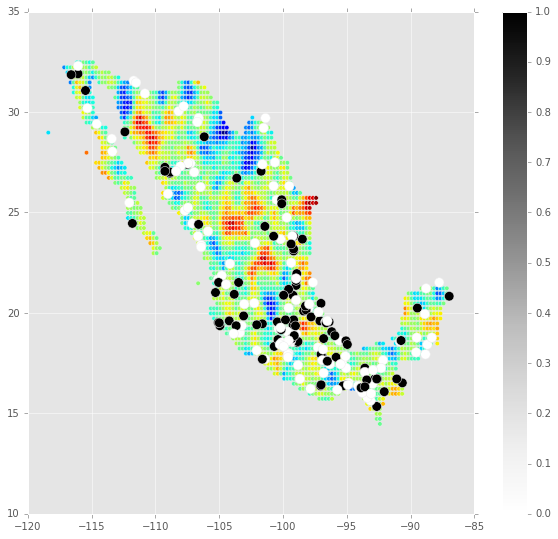

In [39]:
fig, ax = plt.subplots(figsize=(10, 9));
plt.scatter(test1.Longitude,test1.Latitude,c=test1.mean_sample)
plt.scatter(datafull.Longitude,datafull.Latitude,c=datafull.Y,cmap=plt.cm.Greys,s=90)
plt.colorbar()

# Convert to a raster format.
 ## Motivation
 It's important for visualization and compatibility with GIS software to generate the results in a standard raster format.
*Biospytial* Has incorporated tools for reading and converting to the standard raster formats. In this case Geotif.

In [40]:
## Import raster container
from raster_api.tools import RasterContainer

### The easiest way is to take the metadata (geospatial parameters) from one of the RasterData we used as covariates

In [41]:
elv_rast = datadict['Elevation'].rasterdata

In [42]:
predicted_data = test1.mean_sample.values

In [43]:
ncounts_families = RasterContainer(predicted_data,use_metadata_from=elv_rast)

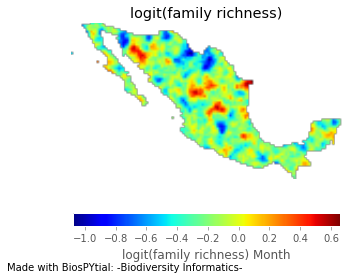

In [46]:
ncounts_families.display_field(band=1,origin='Lower',title='logit(family richness)')

In [47]:
np.log(2)

0.6931471805599453

In [50]:
from scipy.special import expit

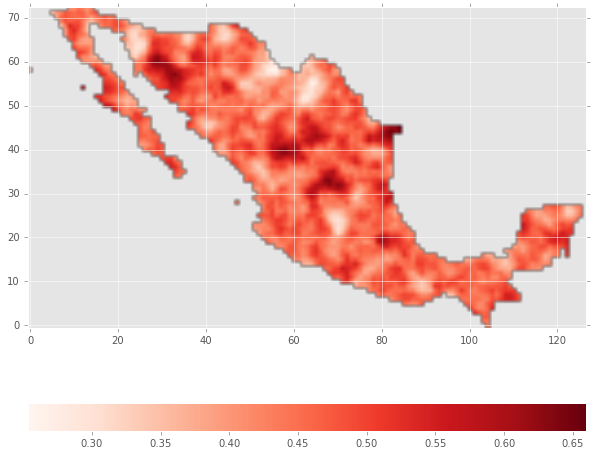

In [52]:
fig, ax = plt.subplots(figsize=(10, 9));

#ncounts_families.display_field(band=2,origin='Lower',title='family richness')
plt.imshow(expit(ncounts_families.rasterdata.bands[0].data()),origin='Lower',cmap=plt.cm.Reds)
plt.colorbar(orientation='horizontal')

## The presences of Poaceas given Bats


In [64]:
## who´s 3073 ??
ff = Family.select(graph,3073)

In [65]:
ff

In [66]:
ff.first()

INFO:neo4j.bolt:~~ [CONNECT] (u'neo4j', 7687)
INFO:neo4j.bolt:~~ [SECURE] neo4j
INFO:neo4j.bolt:C: [HANDSHAKE] 0x6060B017 [1, 0, 0, 0]
INFO:neo4j.bolt:S: [HANDSHAKE] 1
INFO:neo4j.bolt:C: INIT u'py2neo/3.1.1' {}
INFO:neo4j.bolt:S: SUCCESS {u'server': u'Neo4j/3.1.3'}
INFO:neo4j.bolt:C: RUN u'MATCH (_:Family) WHERE _.id = {1} RETURN _' {'1': 3073}
INFO:neo4j.bolt:C: PULL_ALL 
INFO:neo4j.bolt:S: SUCCESS {u'fields': [u'_'], u'result_available_after': 9}
INFO:neo4j.bolt:S: RECORD [('N', (23316, [u'Family'], {u'abundance': 137, u'name': u'Poaceae', u'keyword': u'3073--5--Family--Poaceae', u'level': 5, u'id': 3073, u'levelname': u'Family'}))]
INFO:httpstream:> GET http://neo4j:7474/db/data/
INFO:httpstream:< 200 OK [747]
INFO:neo4j.bolt:S: SUCCESS {u'type': u'r', u'result_consumed_after': 0}


<TreeNode type: Family id = 3073 name: Poaceae>

### Export to Geotif

In [ ]:
ncounts_families.exportToGeoTiff('bats_richness_fromsample')

There are several parameters hidden here:
    1. The size of the predictors grid
    2. The sample size of the training data
    3. The bayesian hyperparameters

## For implementing today
* The modeller function (structure):
    
   * Inputs: 
    
    ** Dataframe for training data
    
    ** numpy n-array or dataframe for predictors
    
    ** Model (specified as Pymc3 model)
    
    * Outputs:
        
        *** The new RasterContainer with rthe bands as: log, exp and expit (in case binomial)
        
* Seems like needs to be a premodelr to select the cells, the geometry, etc.




In [ ]:
ncounts_families.rasterdata.bands[0].data().shape

## stages
1. Build a function for extracting the predictors given a scale parameter
2. Build a function for the "premodeling"
3. Build a function for bundling everything and return the prediction (needs to accept a model)

> Models to run
Show two maps of taxa. e.g. Agave and Bats for instance

Then also show the matrix distance for trees 
